# Modele generatywne; uczenie nienadzorowane

## Sieci kodujące-dekodujące

Jak wiemy z poprzednich zajęć sieci neuronowe pozwalają nam efektywnie zredukować wymiar wejściowego zbioru danych, zazwyczaj w celu odpowiedniej klasyfikacji i predykcji na zadanym zbiorze. Co jednak jeśli jesteśmy zainteresowani tylko redukcją wymiaru danych a nie wnioskowaniem na ich podstawie?

Klasyczna sieć kodująca-dekodująca (<b>autoencoder</b>) pozwala nam na zakodowanie danych (najczęściej obrazu) w formie wektora <b>zmiennych ukrytych</b> <i>(latent variables)</i> i następnie odtworzenie go w możliwie jak najbardziej bezstratnej formie:

[![](http://kvfrans.com/content/images/2016/08/autoenc.jpg)](http://kvfrans.com/variational-autoencoders-explained/)

Tego typu sieci posiadają kilka zastosowań:

- Są efektywnym narzędziem kompresji.
- Można je stosować jako sposób szyfrowania danych.
- Pozwalają na wykrycie nietrywialnych zależności między danymi, które nie są możliwe do uzyskania za pomocą klasycznych algorytmów uczenia nienadzorowanego.

Pokażmy prosty przykład:

In [2]:
using Flux, Flux.Data.MNIST
using Flux: mse, throttle, params, Statistics, @epochs
using Base.Iterators: partition
using Printf, BSON, LinearAlgebra

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv C:\Users\p\.julia\packages\CUDAdrv\mCr0O\src\CUDAdrv.jl:69


In [3]:
X = float.(hcat(vec.(MNIST.images())...))
N, M = size(X, 2), 100
data = [X[:,i] for i in Iterators.partition(1:N,M)];

In [4]:
encoder = Chain(Dense(28^2, 256, leakyrelu),
                Dense(256, 32, leakyrelu))
    
decoder = Chain(Dense(32, 256, leakyrelu), 
                Dense(256, 28^2, leakyrelu))

Chain(Dense(32, 256, leakyrelu), Dense(256, 784, leakyrelu))

In [5]:
model = Chain(encoder, decoder)
loss(x) = mse(model(x), x)
evalcb = throttle(() -> @show(loss(data[1])), 60)
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [ ]:
@info("Beginning training loop...")
best_ls = Inf
last_improvement = 0
for epoch = 1:10
    @info "Epoch $i"
    global best_ls, last_improvement
    Flux.train!(loss, params(model), zip(data), opt, cb = evalcb)
    ls = loss(data[1])
    if ls <= best_ls
        BSON.@save "enc_dec.bson" model epoch
        best_ls = ls
        last_improvement = epoch
    end
    if epoch - last_improvement >= 2
        @warn(" -> We're calling this converged.")
        break
    end
end

In [9]:
using Images

In [7]:
BSON.@load "enc_dec.bson" model 

In [8]:
img(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28))

function sample()
  before = [MNIST.images()[i] for i in rand(1:length(MNIST.images()), 4)]
  after = img.(map(x -> model(float(vec(x))), before))
  vcat(hcat.(before, after)...)
end

sample (generic function with 1 method)

In [11]:
encoder(float(vec(MNIST.images()[1] )))

32-element Array{Float32,1}:
 -0.0031461504 
  0.14641653   
 -0.00053805136
 -0.0028649191 
 -0.010664173  
  0.079312384  
 -0.0014963194 
  0.007531166  
  0.30741718   
  0.17018029   
 -0.004722144  
  0.28534555   
 -0.00289976   
  ⋮            
  0.15918723   
  0.18245387   
  0.10285814   
  1.3044422    
  0.67391187   
 -2.8246232e-5 
 -0.0024048304 
  0.019954836  
 -0.00057598733
  0.28967044   
 -2.0092464e-5 
 -0.0028463914 

Taki model pozwala na całkiem efektywną kompresję wejściowych danych. Jednak co należy zrobić gdy chcielibyśmy generować nowe obrazy na podstawie danych wejściowych a nie jedynie je odtwarzać?


##  Wariacyjne autoenkodery

[Variational Autoencoder](https://arxiv.org/pdf/1312.6114.pdf) jest klasą modeli, która na to pozwala. Intuicja  za nimi stojąca jest prosta, sieć dekodująca zamiast odtwarzać obraz w skali 1:1 dodaje do nich pewną losowość, dzięki której wyjściowy obraz jest nieznacznie zmieniony w stosunku do obrazu wejściowego.

Otrzymanie tej losowości jest możliwe dzięki wygenerowaniu przez sieć kodującą nie tyle wektora zmiennych ukrytych, co wektora średnich i odchyleń standardowych zmiennych ukrytych z których następnie losowane są zmienne ukryte wykorzystane przez sieć dekodującą:

[![](http://kvfrans.com/content/images/2016/08/vae.jpg)](http://kvfrans.com/variational-autoencoders-explained/)

Jak działa taka sieć?

Zgodnie z <b>hipotezą rozmaitości</b> (<i>Manifold hypothesis</i>) o kształcie  zbiorów danych o wysokim wymiarze decyduje tak naprawdę niewielka liczba zmiennych:

[![](https://www.researchgate.net/profile/Y_Bengio/publication/221700451/figure/fig1/AS:305523212734474@1449853818623/Example-of-a-simple-manifold-in-the-space-of-images-associated-with-a-rather-low-level.png)](https://www.researchgate.net/figure/Example-of-a-simple-manifold-in-the-space-of-images-associated-with-a-rather-low-level_fig1_221700451/)

Oznacza to, że do generowania dużyh zbiorów danych $x$ potrzebujemy tak naprawdę wiedzy jedynie o zmiennych ukrytych $z$, które je generują:

[![](https://i.stack.imgur.com/w0HP5.png)](https://stats.stackexchange.com/questions/271522/what-is-the-objective-of-a-variational-autoencoder-vae)

Tym co chcemy znaleźć jest rozkład prawdopodobieństwa $p(x,z)$, który wyjaśnia to w jaki sposób zmienne ukryte kształtują dane:

$$p(x,z) = p(x|z)p(z)$$

Mamy odwrotną informację:

$$p(z|x) = \frac{p(x|z)p(z)}{p(x)}$$

Aby dostać $p(x,z)$ musimy wyznaczyć $p(x) = \int {p(x|z)p(z)}dz$

Jak to zrobić? 
- bezpośrednio?
- generując dane z rozkladu i uśredniając wyniki?


Zamiast tego mozemy wyaproksymowac $p(z|x)$ za pomocą przyjętego rozkladu $Q(z|x; \theta)$, który należy do znanej nam rodziny rozkladów prawdopodobieństwa. Wtedy problem sprowadza się do policzenia::
$$E_{z \tilde{}  Q}[P(x | z)]$$ 


Jak jednak $Q$ ma sie do $p$?


Mozemy to zmierzyc za pomoca Dywergencji Kullbacka-Leiblera:

$$d_{KL}(Q(z|x)||p(z  |  x)) = E_{Q}[\log Q(z|x)] - E_{Q}[\log p(x,z)] + \log p(x)$$

Za zadanie mamy znaleźć takie $Q$, które zminimalizuje dywergencje 


Aby to zrobić zdefiniujmy <b>Evidence Lower BOund</b> (ELBO):

$$ELBO(\theta) = E_{Q}[\log p(x,z)] -  E_{Q}[\log Q(z|x)]$$

Zauważmy, że:

$$\log p(x) = ELBO(\theta) + d_{KL}(Q(z|x)||p(z  |  x))$$

Na mocy nierówności Jensena Dywergencja Kullbacka-Leiblera jest zawsze nieujemna, co oznacza, że problem minimalizacji dywergencji sprowadza się do problemu maksymalizacji ELBO.

Przejdźmy do implementacji modelu:

In [12]:
X = float.(hcat(vec.(MNIST.images())...)) .> 0.5
N, M = size(X, 2), 100
data = [X[:,i] for i in Iterators.partition(1:N,M)];

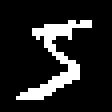

In [19]:
img(Float64.(X[:,1]))

Zdefiniujmy funkcje straty:

In [22]:
# Extend distributions slightly to have a numerically stable logpdf for `p` close to 1 or 0.
using Distributions
import Distributions: logpdf
logpdf(b::Bernoulli, y::Bool) = y * log(b.p + eps(Float32)) + (1f0 - y) * log(1 - b.p + eps(Float32))

logpdf (generic function with 64 methods)

In [23]:
# KL-divergence between approximation posterior and N(0, 1) prior
kl_q_p(μ, logσ) = 0.5f0 * sum(exp.(2f0 .* logσ) + μ.^2 .- 1f0 .+ logσ.^2)

kl_q_p (generic function with 1 method)

In [24]:
# logp(x|z) - conditional probability of data given latents.
logp_x_z(x, z) = sum(logpdf.(Bernoulli.(decoder(z)), x))

logp_x_z (generic function with 1 method)

In [25]:
function ELBO(X)
    μ̂, logσ̂ = μ(encoder(X)), logσ(encoder(X))
     kl_q_p(μ̂, logσ̂) * 1 // M
end

ELBO (generic function with 1 method)

In [26]:
loss(X) = -ELBO(X) 

loss (generic function with 1 method)

I model:

In [ ]:
Dz, Dh = 2, 512 #wymiary

In [ ]:
encoder  = Chain(Dense(28^2, 512, relu))

In [ ]:
μ = Dense(Dh, Dz)
logσ = Dense(Dh, Dz)

In [ ]:
z(μ, logσ) = μ + exp(logσ) * randn(Float32)

In [ ]:
decoder = Chain(Dense(Dz, Dh, relu), 
                Dense(Dh, 28^2, σ))

In [ ]:
evalcb = throttle(() -> @show(loss(X[:, rand(1:N, M)])), 60)
opt = ADAM()
ps = params(encoder, μ, logσ, decoder);

In [ ]:
## @info("Beginning training loop...")
best_ls = Inf
last_improvement = 0
for epoch = 1:10
    @info "Epoch $epoch"
    global best_ls, last_improvement
    Flux.train!(loss, ps, zip(data), opt, cb=evalcb)
    ls = loss(data[1])
    if ls <= best_ls
        BSON.@save "vae.bson" encoder μ logσ decoder
        best_ls = ls
        last_improvement = epoch
    end
    if epoch - last_improvement >= 2
        @warn(" -> We're calling this converged.")
        break
    end
end

Do budowania modeli generatywnych możemy wykorzystać też sieci konwolucyjne:

In [27]:
Dz, Dh = 6, 128 #wymiary

(6, 128)

In [28]:
encoder =  Chain(x -> reshape(x, (28,28,1,100)),
        Conv((3,3), 1=>32, pad = (1,1),relu),
        Conv((3,3), 32=>32, pad = (1,1), relu),
        MaxPool((2, 2)),
        Dropout(0.25),
        x -> reshape(x, :, size(x, 4)),
        Dense(6272, Dh))

μ = Dense(Dh, Dz) 

logσ = Dense(Dh, Dz)

z(μ, logσ) = μ + exp.(logσ) * randn(Float32)

decoder = Chain(Dense(Dz, Dh, relu),
        Dense(Dh,6272, relu),
        x -> reshape(x,(14,14,32,100)),
        Dropout(0.25),
        x -> repeat(x, inner = [2,2,1,1]),
        ConvTranspose((3,3), 32=>32, pad = (1,1),relu),
        ConvTranspose((3,3), 32=>1, pad = (1,1), σ),
        x -> reshape(x, :, size(x, 4))
       )

Chain(Dense(6, 128, relu), Dense(128, 6272, relu), #23, Dropout(0.25), #24, ConvTranspose((3, 3), 32=>32, relu), ConvTranspose((3, 3), 32=>1, σ), #25)

In [29]:
evalcb = throttle(() -> @show(loss(X[:, rand(1:N, M)])), 300)
opt = ADAM()
ps = params(encoder, μ, logσ, decoder);

In [ ]:
@info("Beginning training loop...")
best_ls = Inf
last_improvement = 0
for epoch = 1:10
    @info "Epoch $epoch"
    global best_ls, last_improvement
    Flux.train!(loss, ps, zip(data), opt, cb=evalcb)
    ls = loss(data[1])
    if ls <= best_ls
        BSON.@save "vaeCNN_MNIST.bson" encoder μ logσ decoder
        best_ls = ls
        last_improvement = epoch
    end
    if epoch - last_improvement >= 2
        @warn(" -> We're calling this converged.")
        break
    end
end

In [30]:
BSON.@load "vaeCNN_MNIST.bson" encoder μ logσ decoder 

In [33]:
img(x::Vector) = Gray.(reshape(clamp.(x, 0, 1), 28, 28))

function sample()
    batch = data[rand(1:length(data))]
    latents = encoder(batch)
    Z = z(μ(latents), logσ(latents))
    decoded = decoder(Z)
    idx = rand(1:size(batch,2),4)
    before = [img(Float64.(batch[:,i])) for i in idx]
    after = [img(decoded[:,i]) for i in idx]
    vcat(hcat.(before, after)...)
end

sample (generic function with 1 method)

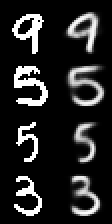

In [34]:
sample()

## Dodatkowa praca domowa

Na podstawie prezentowanego na zajęciach przykładu wyucz wariacyjny autoenkoder w taki sposób żeby reprezentował dane za pomocą wektora dwóch zmiennych ukrytych z możliwie najwyższą dokładnością. Następnie:
1. Przedstaw na wykresie otrzymany wynik. Jak zachowują się zmienne ukryte?
2. Wyucz sieć o takiej samej architekturze korzystając jedynie z warunkowego prawdopodobieństwa $logp(x|z)$ jako funkcji straty. Czym różni się otrzymany wynik? 
3. Wyucz taką samą sieć korzystając jedynie z Dywergencji Kullbacka-Leiblera jako funkcji straty. Ponownie porównaj wynik z poprzednio otrzymanymi.